<a href="https://colab.research.google.com/github/gvigkannan/COVID_CXR/blob/main/Brixia_GlobalScore_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Author: Vignesh Kannan
## Notebook Objective:
## To use the COVID Images from Brixia and use the associated Brixia scores to get a prediction.

## Model Specifically for Brixia Files.

## Libraries


In [ ]:
from __future__ import print_function, division
import numpy as np
import time
import os 
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import pandas as pd
import csv
from PIL import Image, ImageOps
import cv2
from collections import OrderedDict

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, torchsummary
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [ ]:
## XRay Vision Model
## Downloading Torch XRay vision Models
!pip install torchxrayvision
import torchxrayvision as xrv

     |████████████████████████████████| 25.0MB 47.5MB/s 
     |████████████████████████████████| 1.9MB 38.4MB/s 


## Data Related


In [ ]:
## To access the drive files!
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def set_state(random_seed):
  np.random.seed(random_seed)
  torch.manual_seed(random_seed)
  

## Hyperparam


In [ ]:
## Hyperparams!
STEP_FLAG = False
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.01
RANDOM_STATE = 0
MODEL_NAME = "_".join(("BRIXIA_GlobalScore_RS"+str(RANDOM_STATE),"EP"+str(EPOCHS),"ImageNet_v1"))
MODEL_PATH = "/content/drive/MyDrive/Models"
set_state(RANDOM_STATE)

In [ ]:
print(MODEL_NAME)

BRIXIA_GlobalScore_RS0_EP150_ImageNet_v1


## EDA and Preprocessing

In [ ]:
## Loading the dataset
IMG_DIR = "/content/drive/MyDrive/Dataset/1512_raw_converted_Brixia/png"
DATA_PATH ="/content/drive/MyDrive/Dataset/1512_raw_converted_Brixia/Labels"
data_fnames = os.listdir(IMG_DIR)
use_cols = ['Filename', 
            'BrixiaScoreGlobal']
annot_train = pd.read_csv("/content/drive/MyDrive/Dataset/1512_raw_converted_Brixia/Labels/BRIXIA_labels7_train_v1.csv", usecols = use_cols)
annot_test = pd.read_csv("/content/drive/MyDrive/Dataset/1512_raw_converted_Brixia/Labels/BRIXIA_labels7_test_v1.csv", usecols = use_cols)
annot_val = pd.read_csv("/content/drive/MyDrive/Dataset/1512_raw_converted_Brixia/Labels/BRIXIA_labels7_val_v1.csv", usecols = use_cols)

In [ ]:
data_fnames[:5]

['3071481066991796562.png',
 '5349114230435573268.png',
 '14520267977687498982.png',
 '5760155357955515669.png',
 '4533796907911013560.png']

In [ ]:
annot_train.head()

,Filename,BrixiaScoreGlobal
0,15294484260192913106.dcm,1
1,1351581923485041226.dcm,8
2,5509913180488915144.dcm,16
3,16275515214005167160.dcm,1
4,15150980823835766865.dcm,6


In [ ]:
def replace_filename(df):
  """ Replace the .format to match with the specific images! """
  df['Filename'] = df['Filename'].apply(lambda x: x.split(".")[0]).apply(lambda x: ".".join((x, "png")))


In [ ]:
replace_filename(annot_train)
replace_filename(annot_val)
replace_filename(annot_test)

In [ ]:
annot_train.head()

,Filename,BrixiaScoreGlobal
0,15294484260192913106.png,1
1,1351581923485041226.png,8
2,5509913180488915144.png,16
3,16275515214005167160.png,1
4,15150980823835766865.png,6


In [ ]:
## To get the annotations for those files that exist.
annot_train = annot_train.loc[annot_train['Filename'].isin(data_fnames)]
annot_test = annot_test.loc[annot_test['Filename'].isin(data_fnames)]
annot_val = annot_val.loc[annot_val['Filename'].isin(data_fnames)]

# brixia_cohen_covid.to_csv("Brixia_COVID_Cohen.csv")
print("Total Files Accessible for train: ", len(annot_train))
print("Total Files Accessible for test: ", len(annot_test))
print("Total Files Accessible for val: ", len(annot_val))

Total Files Accessible for train:  1366
Total Files Accessible for test:  75
Total Files Accessible for val:  71


In [ ]:
def load_img(filename, target_size = 224):
  """
  Load and resize the grayscale image.
  :param filename: path/filename
  :param target_size: output shape of image
  :return: loaded images as (width, height, 1)
  """

  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  if img is None:
    print("File Couldn't be recognized: {}".format(filename))
    return None

  img = img / 255.0   ## Normalizing.
  img = cv2.resize(img, (target_size, target_size))
  ## To match Pytorch Requirement
  img = np.stack((img,)*3, axis=-1)
  # print(img.shape)
  img = np.reshape(img, (3, target_size, target_size)) ## Reshaping
  # print(img.shape)
  return img

In [ ]:
def shuffle_split(X, y, test_ratio = 0.2):
  """
  Shuffle and Split Dataset
  """
  lenData = len(y)
  ind = np.random.permutation(np.arange(lenData))
  X, y = X[ind], y[ind]
  testX, testY = X[:int(lenData*test_ratio)], y[:int(lenData*test_ratio)]
  trainX, trainY = X[int(lenData*test_ratio):], y[int(lenData*test_ratio):]
  return trainX, trainY, testX, testY



In [ ]:
## New Verion!
def get_data(img_dir, annot_data, target_size= 224 ):
  """
  Get the images and annotation for the given annotated file!
  """
  X, Y = [], []
  ## For all the images
  for idx in tqdm(annot_data.itertuples()):
    ## Loading Images:
    img = load_img(os.path.join(img_dir, idx.Filename), target_size)
    ##To do. Implement Equalize
    Y.append(idx.BrixiaScoreGlobal)  ## For the Senior Score.
    X.append(img)
  X = np.asarray(X).astype(np.float32)
  Y = np.asarray(Y).astype(np.float32) 

  return X, Y
# len_data = len(y)
# # lengths = [int(len_data*(1-test_size)), int(len_data*test_size)]
# trainX, trainY, testX, testY = shuffle_split(X, y, test_ratio = 0.1)

In [ ]:
trainX, trainY = get_data(IMG_DIR, annot_data = annot_train)  ## 26 s
valX, valY = get_data(IMG_DIR, annot_data = annot_val)
testX, testY = get_data(IMG_DIR, annot_data = annot_test)
print("TrainX: ", np.shape(trainX))
print("TrainY: ", np.shape(trainY))

(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)
(224, 224, 3)
(3, 224, 224)



KeyboardInterrupt: ignored

In [ ]:
## Loading a sample image!

sample_img = load_img(os.path.join(IMG_DIR, annot_train.Filename[0]))
sample_img.shape

(3, 224, 224)

In [ ]:
def get_dl(X, y, batch_size, train = False):
  """ Convert dataset into Tensor Dataset and then return it's dataloader """
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
  if train: ## We wish to prioritize randomization during training
    return DataLoader(dataset, batch_size, shuffle = True)
  else:
    return DataLoader(dataset, batch_size*2, shuffle = False)


In [ ]:
## Getting DataLoaders!
train_dl = get_dl(trainX, trainY, BATCH_SIZE, train = True)
val_dl = get_dl(valX, valY, BATCH_SIZE, train = False)
test_dl = get_dl(testX, testY, BATCH_SIZE, train = False)
dataloaders = {'train': train_dl,  'val': val_dl,  'test': test_dl}
data_sizes = {'train': len(trainY),  'val': len(valY),  'test': len(testY)}

In [ ]:
data_sizes

{'test': 75, 'train': 1366, 'val': 71}

In [ ]:
## Creating an Instance of DataLoader!
# train_dl = DataLoader(data, batch_size = 8, shuffle = True)
X, y = next(iter(train_dl))
print(np.shape(X))
print(np.shape(y))

torch.Size([32, 1, 224, 224])
torch.Size([32])


## Model Related

In [ ]:
model_brixia = models.densenet161(pretrained=True)

In [ ]:
model_brixia

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_brixia = xrv.models.DenseNet(weights = 'all')
# for param in model_brixia.parameters():
#   param.requires_grad = False
# model_brixia.op_threshs = None
model_brixia.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# torchsummary.summary(model_brixia, (1, 224, 224))

In [ ]:
FFNN = nn.Sequential(
    nn.Linear(in_features = 2208, out_features = 512),
    nn.ELU(), 
    nn.Dropout(0.4),
    nn.Linear(in_features = 512, out_features = 256),
    nn.ELU(), 
    nn.Dropout(0.4),
    nn.Linear(in_features = 256, out_features = 128),
    nn.ELU(), 
    nn.Dropout(0.4),
    nn.Linear(in_features = 128, out_features = 64),
    nn.ELU(), 
    nn.Linear(in_features = 64, out_features = 32),
    nn.ELU(), 
    nn.Linear(in_features = 32, out_features = 16),
    nn.ELU(), 
    nn.Linear(in_features = 16, out_features = 1))



In [ ]:
## Method 1: Update Existing Model.
model_brixia.classifier = FFNN
model_brixia.to(device)
x = torch.rand((2, 3, 224, 224)).to(device)
torchsummary.summary(model_brixia, x)

TypeError: ignored


### Versions Tried!

- V1:
    - V1_1: 512-256-128-64-1
    - V1_2: 512-256-128-1
    - V1_3: 512-256-1
    - V1_4: 512-128-32-1
    - V1_5: 512-128-1
    - V1_6: 512-1
    - Which is the best: StepLR, ExpLR?
- V2:
    - [ ]  256-128-64-32-1
    - [ ]  256-128-64-1
    - [ ]  256 - 64 - 2
    - [ ]  256-128-1
    - [ ]  256-1
    - 
- V3:
    - [ ]  128 - 64 - 32 - 1
    - [ ]  128 - 32 - 1
    - [ ]  128 - 64 - 1
    - [ ]  128 - 1
    -



## Training Function


In [ ]:
## To do: Training Script!
def train_model(model, criterion, optimizer, scheduler, dataloaders, numEpochs):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()

  best_WandB = copy.deepcopy(model.state_dict())
  best_loss = np.inf 
  train_hist = {}
  val_hist = {}
  ## For all the epochs:
  for epoch in tqdm(range(numEpochs)):
    epoch_loss = 0.0
    start_epoch = time.time()
    if epoch % 50 == 0:
      print("Epoch {}/{}".format(epoch + 1, numEpochs))
      print("*"*10)

    ## For each phase: train vs val
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      ## Tracking loss
      epoch_loss = 0.0

      ## For all phase data:
      for imgs, values in dataloaders[phase]:
        imgs = imgs.to(device)
        values = values.to(device)

        ## Zero the gradients
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, values)
        ## Epoch Stats
        epoch_loss += loss.item() * imgs.size(0)

        ## Forward Prop
        with torch.set_grad_enabled(phase == 'train'):
          ## Backward Prop
          if phase == 'train':
            loss.backward()
            optimizer.step()

        

      epoch_loss = epoch_loss / data_sizes[phase]
      scheduler.step(epoch_loss)
      if phase == 'train':
        train_hist[epoch] = epoch_loss
      else:
        val_hist[epoch] = epoch_loss

      if epoch % 50 == 0:
        print("{}\tLoss: {:.4f}\tTime: {:.4f}".format(phase, epoch_loss, time.time() - start_epoch))
      ## Check for loss: ## We don't check for validation loss
      ## Need to write a function for rmse 


      if phase == 'val' and best_loss > epoch_loss:
        best_loss = epoch_loss
        best_WandB = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'loss': epoch_loss,
            'model_state': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(MODEL_PATH, MODEL_NAME))
        print()
        print("Epoch: ", epoch)
        print("====> New Best Model!: {}".format(MODEL_NAME))
        print()
        print("*"*10)

  ## Loading best model
  print("Best MSE: {:.4f}".format(best_loss))
  print("Total Time: {:.4f}".format(time.time() - start_time)) 
  
  model.load_state_dict(best_WandB)
  return model, train_hist, val_hist




## Training


In [ ]:
# MODEL_NAME = "COVID_COHEN_V3_3_StepLR_RS_trial1.pth"
# MODEL_PATH = "/content/drive/MyDrive/Models"

In [ ]:
FLAG = 110
criterion = nn.MSELoss()
optimizer = optim.Adam(model_brixia.parameters(), lr = LEARNING_RATE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if FLAG ==  0:
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = 0.1, step_size = 10)
elif FLAG == 1:
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
else:
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dl), eta_min=0.0)


In [ ]:
## TODO: Tensorboard Visualization!
MODEL_NAME = "BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3"
model_brixia.to(device)
model_brixia, train_hist, val_hist = train_model(model_brixia, criterion, optimizer, lr_scheduler, dataloaders, EPOCHS)

Epoch 1/500
**********
train	Loss: 62.2881	Time: 0.5582
val	Loss: 76.6906	Time: 0.5901

Epoch:  0
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

**********

Epoch:  1
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

**********

Epoch:  2
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

**********

Epoch:  3
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

**********

Epoch:  4
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

**********
Epoch 51/500
**********
train	Loss: 20.0844	Time: 0.5438
val	Loss: 26.9381	Time: 0.5750
Epoch 101/500
**********
train	Loss: 20.0606	Time: 0.5401
val	Loss: 26.9629	Time: 0.5716
Epoch 151/500
**********
train	Loss: 20.1676	Time: 0.5397
val	Loss: 26.8648	Time: 0.5711
Epoch 201/500
**********
train	Loss: 19.9929	Time: 0.5427
val	Loss: 26.9542	Time: 0.5745

Epoch:  235
====> New Best Model!: BRIXIA_GlobalScore_Temp_RS_0_EXP_EPOCHS_500_v3

*********

In [ ]:
# os.path.join(MODEL_PATH, MODEL_NAME+str(EPOCHS)+".pth")

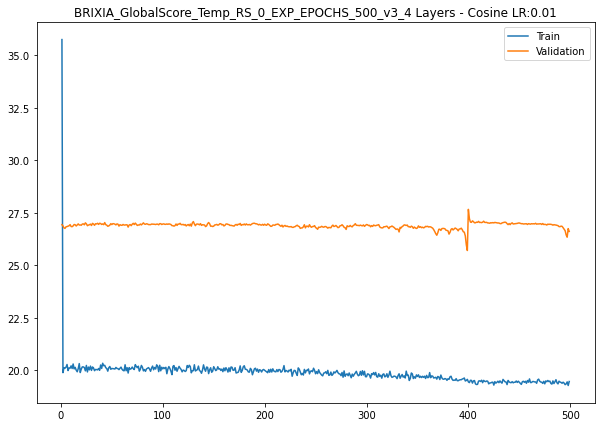

In [ ]:
plt.figure(figsize = (10,7))
lists = sorted(train_hist.items())
train_epoch, train_loss = zip(*lists[1:])
lists = sorted(val_hist.items())
val_epoch, val_loss = zip(*lists[1:])
plt.plot(train_epoch, train_loss, label = 'Train')
plt.plot(val_epoch, val_loss, label = 'Validation')
plt.title(MODEL_NAME+"_4 Layers - Cosine LR:"+str(LEARNING_RATE))
plt.legend()

In [ ]:
def eval_model(model, criterion, eval_loader):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()
  loss_hist = {}
  model.eval()

  ## Tracking loss
  eval_loss = 0.0
  ## For Evaluation Data:
  for imgs, values in eval_loader:
      imgs = imgs.to(device)
      values = values.to(device)

      ## Zero the gradients
      optimizer.zero_grad()
      outputs = model(imgs)
      loss = criterion(outputs, values)
      eval_loss += loss.item() * imgs.size(0)

    
   

  eval_loss = eval_loss / len(eval_loader.dataset)
  print("Loss: {:.4f}\tTime: {:.4f}".format(eval_loss, time.time() - start_time))
  return eval_loss




In [ ]:
## Testing:
print("Train: ")
train_loss = eval_model(model_brixia, criterion, train_dl)
print("Val: ")
val_loss = eval_model(model_brixia, criterion, val_dl)
print("Test: ")
test_out = eval_model(model_brixia, criterion, test_dl)

Train: 
Loss: 19.1256	Time: 0.5899
Val: 
Loss: 25.7024	Time: 0.0313
Test: 
Loss: 15.3829	Time: 0.0338
